In [122]:
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.rnn as rnn
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
from pandas import read_csv
import numpy as np

In [268]:
graph=tf.get_default_graph()
tf.reset_default_graph()

In [269]:
rnn_unit=10        
lstm_layers=2      
input_size=15
output_size=1
lr=0.0006
df = read_csv('demo2.csv',header=0)       
data=df.iloc[:,1:17].values  

print(data)

[[2.60730000e+02 2.70298000e+07 2.67891000e+05 ... 2.56380000e+02
  2.48700000e+02 2.48090000e+02]
 [2.57430000e+02 2.15519000e+07 2.76497000e+05 ... 2.59580000e+02
  2.49990000e+02 2.48810000e+02]
 [2.55600000e+02 1.90338000e+07 2.67584000e+05 ... 2.59030000e+02
  2.51230000e+02 2.49300000e+02]
 ...
 [3.91944000e+03 1.04807896e+10 6.54299000e+05 ... 3.90704000e+03
  3.91655000e+03 3.88832000e+03]
 [3.94253000e+03 9.39421060e+09 6.43452000e+05 ... 3.91342000e+03
  3.91966000e+03 3.89329000e+03]
 [4.01283000e+03 9.85616697e+09 5.45186000e+05 ... 3.93067000e+03
  3.92599000e+03 3.90053000e+03]]


In [270]:
def get_train_data(batch_size=128,time_step=15,train_begin=0,train_end=1200):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   
    for i in range(len(normalized_train_data)-time_step):
       if i % batch_size==0:
           batch_index.append(i)
       x=normalized_train_data[i:i+time_step,:15]
       y=normalized_train_data[i:i+time_step,15,np.newaxis]
       train_x.append(x.tolist())
       train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

In [271]:
def get_test_data(time_step=15,test_begin=1200):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  
    size=(len(normalized_test_data)+time_step-1)//time_step  
    test_x,test_y=[],[]
    for i in range(size-1):
       x=normalized_test_data[i*time_step:(i+1)*time_step,:15]
       y=normalized_test_data[i*time_step:(i+1)*time_step,15]
       test_x.append(x.tolist())
       test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:15]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,15]).tolist())
    return mean,std,test_x,test_y

In [272]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
keep_prob = tf.placeholder(tf.float32, name='keep_prob') 


In [273]:
def lstmCell():
    #basicLstm单元
    basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    # dropout
    drop = tf.nn.rnn_cell.DropoutWrapper(basicLstm, output_keep_prob=0.5)
    return basicLstm

def lstm(X):   
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  
    cell = tf.nn.rnn_cell.MultiRNNCell([lstmCell() for i in range(lstm_layers)])
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [274]:
def train_lstm(batch_size=128,time_step=15,train_begin=0,train_end=1200):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(X)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(10000):    
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]],keep_prob:0.5})
            print("Number of iterations:",i," loss:",loss_)
        print("model_save: ",saver.save(sess,'model_save2/modle.ckpt'))
        #I run the code on windows 10,so use  'model_save2\\modle.ckpt'
        #if you run it on Linux,please use  'model_save2/modle.ckpt'
        print("The train has finished")
train_lstm()

Number of iterations: 0  loss: 1.0375515
Number of iterations: 1  loss: 0.35536098
Number of iterations: 2  loss: 0.12461728
Number of iterations: 3  loss: 0.17927887
Number of iterations: 4  loss: 0.2515675
Number of iterations: 5  loss: 0.2530396
Number of iterations: 6  loss: 0.21182807
Number of iterations: 7  loss: 0.16638675
Number of iterations: 8  loss: 0.13381298
Number of iterations: 9  loss: 0.11447645
Number of iterations: 10  loss: 0.10316458
Number of iterations: 11  loss: 0.09529059
Number of iterations: 12  loss: 0.08834278
Number of iterations: 13  loss: 0.08161708
Number of iterations: 14  loss: 0.07531157
Number of iterations: 15  loss: 0.06960982
Number of iterations: 16  loss: 0.064441785
Number of iterations: 17  loss: 0.059675153
Number of iterations: 18  loss: 0.055250756
Number of iterations: 19  loss: 0.05117722
Number of iterations: 20  loss: 0.04747933
Number of iterations: 21  loss: 0.044164952
Number of iterations: 22  loss: 0.04121593
Number of iterations

Number of iterations: 184  loss: 0.0030288233
Number of iterations: 185  loss: 0.0029936323
Number of iterations: 186  loss: 0.0030134225
Number of iterations: 187  loss: 0.0029637066
Number of iterations: 188  loss: 0.003039984
Number of iterations: 189  loss: 0.0029818886
Number of iterations: 190  loss: 0.0032623361
Number of iterations: 191  loss: 0.0033224353
Number of iterations: 192  loss: 0.0045857094
Number of iterations: 193  loss: 0.0055316836
Number of iterations: 194  loss: 0.011463757
Number of iterations: 195  loss: 0.013037067
Number of iterations: 196  loss: 0.021003325
Number of iterations: 197  loss: 0.011994766
Number of iterations: 198  loss: 0.007572911
Number of iterations: 199  loss: 0.003757528
Number of iterations: 200  loss: 0.0028014367
Number of iterations: 201  loss: 0.0027633272
Number of iterations: 202  loss: 0.002796932
Number of iterations: 203  loss: 0.00275153
Number of iterations: 204  loss: 0.0027370846
Number of iterations: 205  loss: 0.002712494

Number of iterations: 364  loss: 0.004382432
Number of iterations: 365  loss: 0.010024176
Number of iterations: 366  loss: 0.013524876
Number of iterations: 367  loss: 0.02302205
Number of iterations: 368  loss: 0.013625236
Number of iterations: 369  loss: 0.006612019
Number of iterations: 370  loss: 0.0023228189
Number of iterations: 371  loss: 0.0015097876
Number of iterations: 372  loss: 0.0015356542
Number of iterations: 373  loss: 0.0016178243
Number of iterations: 374  loss: 0.0015206198
Number of iterations: 375  loss: 0.0015249865
Number of iterations: 376  loss: 0.001500407
Number of iterations: 377  loss: 0.0015006963
Number of iterations: 378  loss: 0.0014956719
Number of iterations: 379  loss: 0.0014924766
Number of iterations: 380  loss: 0.0014890068
Number of iterations: 381  loss: 0.0014849493
Number of iterations: 382  loss: 0.0014810665
Number of iterations: 383  loss: 0.001476752
Number of iterations: 384  loss: 0.0014724771
Number of iterations: 385  loss: 0.00146799

Number of iterations: 544  loss: 0.00765322
Number of iterations: 545  loss: 0.0017263202
Number of iterations: 546  loss: 0.0011919572
Number of iterations: 547  loss: 0.0014290946
Number of iterations: 548  loss: 0.0012394568
Number of iterations: 549  loss: 0.0012178168
Number of iterations: 550  loss: 0.0011695462
Number of iterations: 551  loss: 0.0011682571
Number of iterations: 552  loss: 0.0011703549
Number of iterations: 553  loss: 0.001162824
Number of iterations: 554  loss: 0.0011629738
Number of iterations: 555  loss: 0.0011579433
Number of iterations: 556  loss: 0.0011557456
Number of iterations: 557  loss: 0.0011522038
Number of iterations: 558  loss: 0.0011490833
Number of iterations: 559  loss: 0.0011457091
Number of iterations: 560  loss: 0.0011422737
Number of iterations: 561  loss: 0.001138796
Number of iterations: 562  loss: 0.0011352376
Number of iterations: 563  loss: 0.0011316682
Number of iterations: 564  loss: 0.0011280482
Number of iterations: 565  loss: 0.001

Number of iterations: 724  loss: 0.00089235883
Number of iterations: 725  loss: 0.0008895701
Number of iterations: 726  loss: 0.0008868067
Number of iterations: 727  loss: 0.00088407286
Number of iterations: 728  loss: 0.00088136207
Number of iterations: 729  loss: 0.0008786863
Number of iterations: 730  loss: 0.00087602675
Number of iterations: 731  loss: 0.0008734019
Number of iterations: 732  loss: 0.00087079464
Number of iterations: 733  loss: 0.00086822186
Number of iterations: 734  loss: 0.0008656638
Number of iterations: 735  loss: 0.0008631365
Number of iterations: 736  loss: 0.0008606278
Number of iterations: 737  loss: 0.00085814594
Number of iterations: 738  loss: 0.00085569214
Number of iterations: 739  loss: 0.000853242
Number of iterations: 740  loss: 0.0008508709
Number of iterations: 741  loss: 0.0008484321
Number of iterations: 742  loss: 0.0008462443
Number of iterations: 743  loss: 0.0008437973
Number of iterations: 744  loss: 0.00084222865
Number of iterations: 745 

Number of iterations: 902  loss: 0.0007314826
Number of iterations: 903  loss: 0.0007296898
Number of iterations: 904  loss: 0.00072807283
Number of iterations: 905  loss: 0.0007262471
Number of iterations: 906  loss: 0.00072480575
Number of iterations: 907  loss: 0.0007228341
Number of iterations: 908  loss: 0.0007217843
Number of iterations: 909  loss: 0.0007194018
Number of iterations: 910  loss: 0.0007194173
Number of iterations: 911  loss: 0.0007160994
Number of iterations: 912  loss: 0.00071964716
Number of iterations: 913  loss: 0.0007154357
Number of iterations: 914  loss: 0.0007341481
Number of iterations: 915  loss: 0.0007410396
Number of iterations: 916  loss: 0.00084790774
Number of iterations: 917  loss: 0.0009982677
Number of iterations: 918  loss: 0.0017911611
Number of iterations: 919  loss: 0.0032539342
Number of iterations: 920  loss: 0.0104258545
Number of iterations: 921  loss: 0.018334918
Number of iterations: 922  loss: 0.036379684
Number of iterations: 923  loss:

Number of iterations: 1079  loss: 0.00071307324
Number of iterations: 1080  loss: 0.0007103606
Number of iterations: 1081  loss: 0.0007085175
Number of iterations: 1082  loss: 0.0007058869
Number of iterations: 1083  loss: 0.0007046697
Number of iterations: 1084  loss: 0.0007030187
Number of iterations: 1085  loss: 0.0007017423
Number of iterations: 1086  loss: 0.00070042186
Number of iterations: 1087  loss: 0.0006990943
Number of iterations: 1088  loss: 0.00069783797
Number of iterations: 1089  loss: 0.0006965597
Number of iterations: 1090  loss: 0.0006953291
Number of iterations: 1091  loss: 0.0006940998
Number of iterations: 1092  loss: 0.00069290167
Number of iterations: 1093  loss: 0.0006917209
Number of iterations: 1094  loss: 0.00069056835
Number of iterations: 1095  loss: 0.0006894399
Number of iterations: 1096  loss: 0.0006883386
Number of iterations: 1097  loss: 0.0006872662
Number of iterations: 1098  loss: 0.00068622094
Number of iterations: 1099  loss: 0.00068520627
Number

Number of iterations: 1253  loss: 0.00063347665
Number of iterations: 1254  loss: 0.00063299213
Number of iterations: 1255  loss: 0.0006325194
Number of iterations: 1256  loss: 0.0006320559
Number of iterations: 1257  loss: 0.0006316009
Number of iterations: 1258  loss: 0.0006311531
Number of iterations: 1259  loss: 0.00063071033
Number of iterations: 1260  loss: 0.00063027214
Number of iterations: 1261  loss: 0.00062983687
Number of iterations: 1262  loss: 0.0006294027
Number of iterations: 1263  loss: 0.00062896986
Number of iterations: 1264  loss: 0.00062853366
Number of iterations: 1265  loss: 0.0006280981
Number of iterations: 1266  loss: 0.0006276584
Number of iterations: 1267  loss: 0.0006272179
Number of iterations: 1268  loss: 0.0006267666
Number of iterations: 1269  loss: 0.00062631746
Number of iterations: 1270  loss: 0.0006258497
Number of iterations: 1271  loss: 0.0006253933
Number of iterations: 1272  loss: 0.00062490336
Number of iterations: 1273  loss: 0.00062444556
Num

Number of iterations: 1427  loss: 0.00057506945
Number of iterations: 1428  loss: 0.0005746344
Number of iterations: 1429  loss: 0.00057406054
Number of iterations: 1430  loss: 0.0005736766
Number of iterations: 1431  loss: 0.00057295134
Number of iterations: 1432  loss: 0.0005727574
Number of iterations: 1433  loss: 0.00057168445
Number of iterations: 1434  loss: 0.0005721452
Number of iterations: 1435  loss: 0.00057026284
Number of iterations: 1436  loss: 0.0005731562
Number of iterations: 1437  loss: 0.0005701761
Number of iterations: 1438  loss: 0.0005844443
Number of iterations: 1439  loss: 0.00058950327
Number of iterations: 1440  loss: 0.00067757606
Number of iterations: 1441  loss: 0.0008155726
Number of iterations: 1442  loss: 0.001558181
Number of iterations: 1443  loss: 0.0031003784
Number of iterations: 1444  loss: 0.010818027
Number of iterations: 1445  loss: 0.019126423
Number of iterations: 1446  loss: 0.039155763
Number of iterations: 1447  loss: 0.010400224
Number of i

Number of iterations: 1601  loss: 0.0010376221
Number of iterations: 1602  loss: 0.0019033257
Number of iterations: 1603  loss: 0.006241037
Number of iterations: 1604  loss: 0.013208093
Number of iterations: 1605  loss: 0.03723279
Number of iterations: 1606  loss: 0.017512094
Number of iterations: 1607  loss: 0.0068788673
Number of iterations: 1608  loss: 0.0006025326
Number of iterations: 1609  loss: 0.0013385653
Number of iterations: 1610  loss: 0.0006928542
Number of iterations: 1611  loss: 0.0005995705
Number of iterations: 1612  loss: 0.00057409273
Number of iterations: 1613  loss: 0.00054645207
Number of iterations: 1614  loss: 0.00054245006
Number of iterations: 1615  loss: 0.0005312599
Number of iterations: 1616  loss: 0.00052667694
Number of iterations: 1617  loss: 0.0005273142
Number of iterations: 1618  loss: 0.0005218698
Number of iterations: 1619  loss: 0.00052072265
Number of iterations: 1620  loss: 0.00051896076
Number of iterations: 1621  loss: 0.00051718793
Number of i

Number of iterations: 1775  loss: 0.0004727048
Number of iterations: 1776  loss: 0.00047142364
Number of iterations: 1777  loss: 0.0004700459
Number of iterations: 1778  loss: 0.00046891044
Number of iterations: 1779  loss: 0.00046783243
Number of iterations: 1780  loss: 0.00046686205
Number of iterations: 1781  loss: 0.00046598774
Number of iterations: 1782  loss: 0.0004651887
Number of iterations: 1783  loss: 0.0004644763
Number of iterations: 1784  loss: 0.00046383223
Number of iterations: 1785  loss: 0.00046325428
Number of iterations: 1786  loss: 0.0004627361
Number of iterations: 1787  loss: 0.0004622717
Number of iterations: 1788  loss: 0.00046185518
Number of iterations: 1789  loss: 0.00046148192
Number of iterations: 1790  loss: 0.00046114638
Number of iterations: 1791  loss: 0.00046084376
Number of iterations: 1792  loss: 0.00046057068
Number of iterations: 1793  loss: 0.00046032164
Number of iterations: 1794  loss: 0.00046009335
Number of iterations: 1795  loss: 0.0004598815

Number of iterations: 1949  loss: 0.00041551396
Number of iterations: 1950  loss: 0.00041526908
Number of iterations: 1951  loss: 0.00041504257
Number of iterations: 1952  loss: 0.00041483188
Number of iterations: 1953  loss: 0.00041463395
Number of iterations: 1954  loss: 0.00041444466
Number of iterations: 1955  loss: 0.0004142616
Number of iterations: 1956  loss: 0.00041408103
Number of iterations: 1957  loss: 0.0004139033
Number of iterations: 1958  loss: 0.0004137231
Number of iterations: 1959  loss: 0.00041354017
Number of iterations: 1960  loss: 0.00041335236
Number of iterations: 1961  loss: 0.0004131596
Number of iterations: 1962  loss: 0.0004129561
Number of iterations: 1963  loss: 0.00041275
Number of iterations: 1964  loss: 0.00041252797
Number of iterations: 1965  loss: 0.00041230343
Number of iterations: 1966  loss: 0.0004120576
Number of iterations: 1967  loss: 0.00041181588
Number of iterations: 1968  loss: 0.00041153934
Number of iterations: 1969  loss: 0.00041128322
N

Number of iterations: 2123  loss: 0.00037668276
Number of iterations: 2124  loss: 0.00037499337
Number of iterations: 2125  loss: 0.00037830035
Number of iterations: 2126  loss: 0.00037593496
Number of iterations: 2127  loss: 0.00039043784
Number of iterations: 2128  loss: 0.00039726487
Number of iterations: 2129  loss: 0.00047949064
Number of iterations: 2130  loss: 0.00060730724
Number of iterations: 2131  loss: 0.0012263382
Number of iterations: 2132  loss: 0.0024484457
Number of iterations: 2133  loss: 0.007741787
Number of iterations: 2134  loss: 0.0128733395
Number of iterations: 2135  loss: 0.0264569
Number of iterations: 2136  loss: 0.008212286
Number of iterations: 2137  loss: 0.0024765462
Number of iterations: 2138  loss: 0.0004597033
Number of iterations: 2139  loss: 0.00090426125
Number of iterations: 2140  loss: 0.00048997696
Number of iterations: 2141  loss: 0.00044343798
Number of iterations: 2142  loss: 0.00042131805
Number of iterations: 2143  loss: 0.0004119598
Number

Number of iterations: 2297  loss: 0.0003455657
Number of iterations: 2298  loss: 0.00034465024
Number of iterations: 2299  loss: 0.0003438453
Number of iterations: 2300  loss: 0.00034314103
Number of iterations: 2301  loss: 0.00034252246
Number of iterations: 2302  loss: 0.0003419772
Number of iterations: 2303  loss: 0.00034149492
Number of iterations: 2304  loss: 0.0003410649
Number of iterations: 2305  loss: 0.00034068106
Number of iterations: 2306  loss: 0.0003403331
Number of iterations: 2307  loss: 0.00034001784
Number of iterations: 2308  loss: 0.00033972363
Number of iterations: 2309  loss: 0.00033945116
Number of iterations: 2310  loss: 0.00033919135
Number of iterations: 2311  loss: 0.000338946
Number of iterations: 2312  loss: 0.00033870514
Number of iterations: 2313  loss: 0.0003384731
Number of iterations: 2314  loss: 0.000338238
Number of iterations: 2315  loss: 0.0003380098
Number of iterations: 2316  loss: 0.00033777117
Number of iterations: 2317  loss: 0.00033754116
Num

Number of iterations: 2471  loss: 0.00032849782
Number of iterations: 2472  loss: 0.0003338979
Number of iterations: 2473  loss: 0.00042598203
Number of iterations: 2474  loss: 0.00054535555
Number of iterations: 2475  loss: 0.0011456265
Number of iterations: 2476  loss: 0.0021804562
Number of iterations: 2477  loss: 0.0064864145
Number of iterations: 2478  loss: 0.009917374
Number of iterations: 2479  loss: 0.019879878
Number of iterations: 2480  loss: 0.006714714
Number of iterations: 2481  loss: 0.0026826516
Number of iterations: 2482  loss: 0.00040439464
Number of iterations: 2483  loss: 0.00067620556
Number of iterations: 2484  loss: 0.0004544316
Number of iterations: 2485  loss: 0.00040510332
Number of iterations: 2486  loss: 0.0003650254
Number of iterations: 2487  loss: 0.0003579183
Number of iterations: 2488  loss: 0.00035852272
Number of iterations: 2489  loss: 0.00034487015
Number of iterations: 2490  loss: 0.000340955
Number of iterations: 2491  loss: 0.00033552482
Number o

Number of iterations: 2645  loss: 0.0002890951
Number of iterations: 2646  loss: 0.00028868302
Number of iterations: 2647  loss: 0.00028829952
Number of iterations: 2648  loss: 0.0002879471
Number of iterations: 2649  loss: 0.00028761043
Number of iterations: 2650  loss: 0.00028729846
Number of iterations: 2651  loss: 0.00028699305
Number of iterations: 2652  loss: 0.00028670824
Number of iterations: 2653  loss: 0.00028642145
Number of iterations: 2654  loss: 0.00028615637
Number of iterations: 2655  loss: 0.0002858791
Number of iterations: 2656  loss: 0.0002856277
Number of iterations: 2657  loss: 0.00028535078
Number of iterations: 2658  loss: 0.0002851144
Number of iterations: 2659  loss: 0.00028482723
Number of iterations: 2660  loss: 0.000284611
Number of iterations: 2661  loss: 0.00028429847
Number of iterations: 2662  loss: 0.00028412038
Number of iterations: 2663  loss: 0.00028374966
Number of iterations: 2664  loss: 0.0002836554
Number of iterations: 2665  loss: 0.00028315722


Number of iterations: 2819  loss: 0.00043725903
Number of iterations: 2820  loss: 0.00060971343
Number of iterations: 2821  loss: 0.00043810083
Number of iterations: 2822  loss: 0.0003917782
Number of iterations: 2823  loss: 0.00034017544
Number of iterations: 2824  loss: 0.00032998872
Number of iterations: 2825  loss: 0.00032898338
Number of iterations: 2826  loss: 0.00031402422
Number of iterations: 2827  loss: 0.0003084645
Number of iterations: 2828  loss: 0.00030177622
Number of iterations: 2829  loss: 0.00029685957
Number of iterations: 2830  loss: 0.00029270625
Number of iterations: 2831  loss: 0.00028887106
Number of iterations: 2832  loss: 0.0002857173
Number of iterations: 2833  loss: 0.0002829299
Number of iterations: 2834  loss: 0.00028054463
Number of iterations: 2835  loss: 0.00027848966
Number of iterations: 2836  loss: 0.00027670176
Number of iterations: 2837  loss: 0.0002751654
Number of iterations: 2838  loss: 0.00027382135
Number of iterations: 2839  loss: 0.000272658

Number of iterations: 2993  loss: 0.00025376063
Number of iterations: 2994  loss: 0.00024976587
Number of iterations: 2995  loss: 0.00026228637
Number of iterations: 2996  loss: 0.00025920698
Number of iterations: 2997  loss: 0.00030311765
Number of iterations: 2998  loss: 0.00032938947
Number of iterations: 2999  loss: 0.00052908773
Number of iterations: 3000  loss: 0.0007858375
Number of iterations: 3001  loss: 0.00188964
Number of iterations: 3002  loss: 0.0032397322
Number of iterations: 3003  loss: 0.008119097
Number of iterations: 3004  loss: 0.0076478296
Number of iterations: 3005  loss: 0.009943786
Number of iterations: 3006  loss: 0.0023090239
Number of iterations: 3007  loss: 0.00057698105
Number of iterations: 3008  loss: 0.0003353094
Number of iterations: 3009  loss: 0.00043173326
Number of iterations: 3010  loss: 0.00035450616
Number of iterations: 3011  loss: 0.00032000232
Number of iterations: 3012  loss: 0.0002998555
Number of iterations: 3013  loss: 0.0002919728
Number

Number of iterations: 3166  loss: 0.00023579413
Number of iterations: 3167  loss: 0.00023512948
Number of iterations: 3168  loss: 0.00023558752
Number of iterations: 3169  loss: 0.00023449701
Number of iterations: 3170  loss: 0.00023573097
Number of iterations: 3171  loss: 0.00023377904
Number of iterations: 3172  loss: 0.00023699542
Number of iterations: 3173  loss: 0.00023356946
Number of iterations: 3174  loss: 0.0002427725
Number of iterations: 3175  loss: 0.0002389394
Number of iterations: 3176  loss: 0.00027118926
Number of iterations: 3177  loss: 0.0002862169
Number of iterations: 3178  loss: 0.00043466105
Number of iterations: 3179  loss: 0.00062378234
Number of iterations: 3180  loss: 0.0014843942
Number of iterations: 3181  loss: 0.002665955
Number of iterations: 3182  loss: 0.007088759
Number of iterations: 3183  loss: 0.0076186177
Number of iterations: 3184  loss: 0.011110858
Number of iterations: 3185  loss: 0.0027146847
Number of iterations: 3186  loss: 0.0007065298
Numbe

Number of iterations: 3339  loss: 0.00022396154
Number of iterations: 3340  loss: 0.00022362989
Number of iterations: 3341  loss: 0.00022347388
Number of iterations: 3342  loss: 0.00022312194
Number of iterations: 3343  loss: 0.00022304249
Number of iterations: 3344  loss: 0.00022263009
Number of iterations: 3345  loss: 0.00022267076
Number of iterations: 3346  loss: 0.00022212857
Number of iterations: 3347  loss: 0.0002223901
Number of iterations: 3348  loss: 0.00022158287
Number of iterations: 3349  loss: 0.00022229475
Number of iterations: 3350  loss: 0.0002209546
Number of iterations: 3351  loss: 0.00022267745
Number of iterations: 3352  loss: 0.0002203265
Number of iterations: 3353  loss: 0.00022462619
Number of iterations: 3354  loss: 0.00022078014
Number of iterations: 3355  loss: 0.00023296505
Number of iterations: 3356  loss: 0.00023013858
Number of iterations: 3357  loss: 0.00027311628
Number of iterations: 3358  loss: 0.00029997985
Number of iterations: 3359  loss: 0.0004977

Number of iterations: 3511  loss: 0.00021504212
Number of iterations: 3512  loss: 0.00021456296
Number of iterations: 3513  loss: 0.00021413084
Number of iterations: 3514  loss: 0.00021374183
Number of iterations: 3515  loss: 0.0002133864
Number of iterations: 3516  loss: 0.0002130589
Number of iterations: 3517  loss: 0.00021275772
Number of iterations: 3518  loss: 0.00021247435
Number of iterations: 3519  loss: 0.00021221036
Number of iterations: 3520  loss: 0.00021196046
Number of iterations: 3521  loss: 0.00021172345
Number of iterations: 3522  loss: 0.00021149652
Number of iterations: 3523  loss: 0.0002112802
Number of iterations: 3524  loss: 0.0002110691
Number of iterations: 3525  loss: 0.0002108695
Number of iterations: 3526  loss: 0.00021066997
Number of iterations: 3527  loss: 0.000210484
Number of iterations: 3528  loss: 0.00021028981
Number of iterations: 3529  loss: 0.00021011784
Number of iterations: 3530  loss: 0.00020992404
Number of iterations: 3531  loss: 0.0002097688


Number of iterations: 3684  loss: 0.0019035145
Number of iterations: 3685  loss: 0.0032596837
Number of iterations: 3686  loss: 0.007890264
Number of iterations: 3687  loss: 0.0063148625
Number of iterations: 3688  loss: 0.006967856
Number of iterations: 3689  loss: 0.001384195
Number of iterations: 3690  loss: 0.0003391555
Number of iterations: 3691  loss: 0.00030991866
Number of iterations: 3692  loss: 0.0003712826
Number of iterations: 3693  loss: 0.00030184013
Number of iterations: 3694  loss: 0.00026959315
Number of iterations: 3695  loss: 0.00025425342
Number of iterations: 3696  loss: 0.00024522367
Number of iterations: 3697  loss: 0.00023856193
Number of iterations: 3698  loss: 0.00023206371
Number of iterations: 3699  loss: 0.00022641629
Number of iterations: 3700  loss: 0.00022235207
Number of iterations: 3701  loss: 0.00021866876
Number of iterations: 3702  loss: 0.00021587352
Number of iterations: 3703  loss: 0.00021343851
Number of iterations: 3704  loss: 0.00021142233
Num

Number of iterations: 3856  loss: 0.0001911171
Number of iterations: 3857  loss: 0.00019248675
Number of iterations: 3858  loss: 0.00019061271
Number of iterations: 3859  loss: 0.00019400314
Number of iterations: 3860  loss: 0.00019090634
Number of iterations: 3861  loss: 0.00020045138
Number of iterations: 3862  loss: 0.00019801158
Number of iterations: 3863  loss: 0.00023152468
Number of iterations: 3864  loss: 0.000252064
Number of iterations: 3865  loss: 0.0004062248
Number of iterations: 3866  loss: 0.00061099266
Number of iterations: 3867  loss: 0.0014761308
Number of iterations: 3868  loss: 0.0025787149
Number of iterations: 3869  loss: 0.0064466223
Number of iterations: 3870  loss: 0.006069951
Number of iterations: 3871  loss: 0.0077794287
Number of iterations: 3872  loss: 0.0018060202
Number of iterations: 3873  loss: 0.00044747995
Number of iterations: 3874  loss: 0.0002919445
Number of iterations: 3875  loss: 0.00036346383
Number of iterations: 3876  loss: 0.00029994777
Numb

Number of iterations: 4028  loss: 0.00018449356
Number of iterations: 4029  loss: 0.00018426168
Number of iterations: 4030  loss: 0.00018414915
Number of iterations: 4031  loss: 0.00018391061
Number of iterations: 4032  loss: 0.00018384392
Number of iterations: 4033  loss: 0.00018357439
Number of iterations: 4034  loss: 0.00018357793
Number of iterations: 4035  loss: 0.00018324019
Number of iterations: 4036  loss: 0.0001833632
Number of iterations: 4037  loss: 0.00018288511
Number of iterations: 4038  loss: 0.00018323779
Number of iterations: 4039  loss: 0.0001824806
Number of iterations: 4040  loss: 0.00018331542
Number of iterations: 4041  loss: 0.00018201493
Number of iterations: 4042  loss: 0.00018397802
Number of iterations: 4043  loss: 0.00018171771
Number of iterations: 4044  loss: 0.00018673156
Number of iterations: 4045  loss: 0.00018354417
Number of iterations: 4046  loss: 0.00019876298
Number of iterations: 4047  loss: 0.00020066039
Number of iterations: 4048  loss: 0.000260

Number of iterations: 4200  loss: 0.00018127308
Number of iterations: 4201  loss: 0.00018057278
Number of iterations: 4202  loss: 0.00017995623
Number of iterations: 4203  loss: 0.00017944332
Number of iterations: 4204  loss: 0.00017898105
Number of iterations: 4205  loss: 0.0001785927
Number of iterations: 4206  loss: 0.00017823263
Number of iterations: 4207  loss: 0.00017792985
Number of iterations: 4208  loss: 0.00017764022
Number of iterations: 4209  loss: 0.00017739627
Number of iterations: 4210  loss: 0.00017715285
Number of iterations: 4211  loss: 0.00017695311
Number of iterations: 4212  loss: 0.00017674087
Number of iterations: 4213  loss: 0.00017657276
Number of iterations: 4214  loss: 0.00017638042
Number of iterations: 4215  loss: 0.00017624027
Number of iterations: 4216  loss: 0.00017605696
Number of iterations: 4217  loss: 0.0001759406
Number of iterations: 4218  loss: 0.0001757579
Number of iterations: 4219  loss: 0.0001756701
Number of iterations: 4220  loss: 0.00017547

Number of iterations: 4373  loss: 0.010987573
Number of iterations: 4374  loss: 0.0025077623
Number of iterations: 4375  loss: 0.000568726
Number of iterations: 4376  loss: 0.00031241536
Number of iterations: 4377  loss: 0.0004549952
Number of iterations: 4378  loss: 0.00031076034
Number of iterations: 4379  loss: 0.00025724663
Number of iterations: 4380  loss: 0.00024135687
Number of iterations: 4381  loss: 0.00022854391
Number of iterations: 4382  loss: 0.00021857691
Number of iterations: 4383  loss: 0.00020906547
Number of iterations: 4384  loss: 0.00020113836
Number of iterations: 4385  loss: 0.00019555891
Number of iterations: 4386  loss: 0.00019113795
Number of iterations: 4387  loss: 0.00018719304
Number of iterations: 4388  loss: 0.00018438713
Number of iterations: 4389  loss: 0.0001817188
Number of iterations: 4390  loss: 0.00017979453
Number of iterations: 4391  loss: 0.00017802884
Number of iterations: 4392  loss: 0.00017666705
Number of iterations: 4393  loss: 0.00017547079

Number of iterations: 4545  loss: 0.00016388707
Number of iterations: 4546  loss: 0.00016376702
Number of iterations: 4547  loss: 0.00016359356
Number of iterations: 4548  loss: 0.00016350043
Number of iterations: 4549  loss: 0.000163328
Number of iterations: 4550  loss: 0.00016326459
Number of iterations: 4551  loss: 0.00016308033
Number of iterations: 4552  loss: 0.00016305524
Number of iterations: 4553  loss: 0.00016283945
Number of iterations: 4554  loss: 0.00016287428
Number of iterations: 4555  loss: 0.00016259433
Number of iterations: 4556  loss: 0.0001627335
Number of iterations: 4557  loss: 0.00016232599
Number of iterations: 4558  loss: 0.00016266844
Number of iterations: 4559  loss: 0.00016201483
Number of iterations: 4560  loss: 0.00016278638
Number of iterations: 4561  loss: 0.00016166606
Number of iterations: 4562  loss: 0.00016344087
Number of iterations: 4563  loss: 0.00016154088
Number of iterations: 4564  loss: 0.00016604741
Number of iterations: 4565  loss: 0.0001635

Number of iterations: 4717  loss: 0.00016413716
Number of iterations: 4718  loss: 0.00016293264
Number of iterations: 4719  loss: 0.00016206398
Number of iterations: 4720  loss: 0.00016127764
Number of iterations: 4721  loss: 0.00016067435
Number of iterations: 4722  loss: 0.00016013415
Number of iterations: 4723  loss: 0.00015970775
Number of iterations: 4724  loss: 0.00015932065
Number of iterations: 4725  loss: 0.00015900952
Number of iterations: 4726  loss: 0.0001587201
Number of iterations: 4727  loss: 0.00015848619
Number of iterations: 4728  loss: 0.00015825965
Number of iterations: 4729  loss: 0.00015807881
Number of iterations: 4730  loss: 0.00015789259
Number of iterations: 4731  loss: 0.0001577486
Number of iterations: 4732  loss: 0.00015758877
Number of iterations: 4733  loss: 0.00015747198
Number of iterations: 4734  loss: 0.00015732681
Number of iterations: 4735  loss: 0.0001572319
Number of iterations: 4736  loss: 0.00015709281
Number of iterations: 4737  loss: 0.0001570

Number of iterations: 4890  loss: 0.0031953193
Number of iterations: 4891  loss: 0.006756755
Number of iterations: 4892  loss: 0.0040988806
Number of iterations: 4893  loss: 0.0033368096
Number of iterations: 4894  loss: 0.0006928896
Number of iterations: 4895  loss: 0.00025474734
Number of iterations: 4896  loss: 0.00025842237
Number of iterations: 4897  loss: 0.00025725437
Number of iterations: 4898  loss: 0.00022393845
Number of iterations: 4899  loss: 0.00019768582
Number of iterations: 4900  loss: 0.00018661788
Number of iterations: 4901  loss: 0.00017966366
Number of iterations: 4902  loss: 0.00017321957
Number of iterations: 4903  loss: 0.00016977759
Number of iterations: 4904  loss: 0.00016516703
Number of iterations: 4905  loss: 0.00016310251
Number of iterations: 4906  loss: 0.00016047736
Number of iterations: 4907  loss: 0.00015905855
Number of iterations: 4908  loss: 0.00015753291
Number of iterations: 4909  loss: 0.00015655837
Number of iterations: 4910  loss: 0.0001556178

Number of iterations: 5062  loss: 0.00014719882
Number of iterations: 5063  loss: 0.0001469462
Number of iterations: 5064  loss: 0.00014711924
Number of iterations: 5065  loss: 0.00014672386
Number of iterations: 5066  loss: 0.00014712822
Number of iterations: 5067  loss: 0.0001464602
Number of iterations: 5068  loss: 0.00014739312
Number of iterations: 5069  loss: 0.00014623564
Number of iterations: 5070  loss: 0.00014853501
Number of iterations: 5071  loss: 0.000146771
Number of iterations: 5072  loss: 0.00015333436
Number of iterations: 5073  loss: 0.00015284111
Number of iterations: 5074  loss: 0.00017632796
Number of iterations: 5075  loss: 0.00019450106
Number of iterations: 5076  loss: 0.00030306244
Number of iterations: 5077  loss: 0.0004566147
Number of iterations: 5078  loss: 0.0010560784
Number of iterations: 5079  loss: 0.001855732
Number of iterations: 5080  loss: 0.004546963
Number of iterations: 5081  loss: 0.004577043
Number of iterations: 5082  loss: 0.0061290874
Numbe

Number of iterations: 5234  loss: 0.00014350482
Number of iterations: 5235  loss: 0.00014335562
Number of iterations: 5236  loss: 0.00014330835
Number of iterations: 5237  loss: 0.00014317004
Number of iterations: 5238  loss: 0.0001431453
Number of iterations: 5239  loss: 0.00014300551
Number of iterations: 5240  loss: 0.00014300617
Number of iterations: 5241  loss: 0.00014284987
Number of iterations: 5242  loss: 0.00014288347
Number of iterations: 5243  loss: 0.00014269356
Number of iterations: 5244  loss: 0.00014277783
Number of iterations: 5245  loss: 0.00014252635
Number of iterations: 5246  loss: 0.00014269946
Number of iterations: 5247  loss: 0.00014233755
Number of iterations: 5248  loss: 0.00014267639
Number of iterations: 5249  loss: 0.00014211779
Number of iterations: 5250  loss: 0.00014278921
Number of iterations: 5251  loss: 0.00014188534
Number of iterations: 5252  loss: 0.00014328714
Number of iterations: 5253  loss: 0.00014183928
Number of iterations: 5254  loss: 0.00014

Number of iterations: 5406  loss: 0.00013939007
Number of iterations: 5407  loss: 0.00013898924
Number of iterations: 5408  loss: 0.00013936276
Number of iterations: 5409  loss: 0.0001387989
Number of iterations: 5410  loss: 0.00013943108
Number of iterations: 5411  loss: 0.00013859353
Number of iterations: 5412  loss: 0.00013972887
Number of iterations: 5413  loss: 0.0001384537
Number of iterations: 5414  loss: 0.00014067267
Number of iterations: 5415  loss: 0.00013881533
Number of iterations: 5416  loss: 0.00014370792
Number of iterations: 5417  loss: 0.00014177039
Number of iterations: 5418  loss: 0.00015453572
Number of iterations: 5419  loss: 0.00015724504
Number of iterations: 5420  loss: 0.00019831104
Number of iterations: 5421  loss: 0.00023296806
Number of iterations: 5422  loss: 0.00039460926
Number of iterations: 5423  loss: 0.00058879895
Number of iterations: 5424  loss: 0.00128241
Number of iterations: 5425  loss: 0.0019070038
Number of iterations: 5426  loss: 0.0039332667

Number of iterations: 5578  loss: 0.0001509019
Number of iterations: 5579  loss: 0.00015351205
Number of iterations: 5580  loss: 0.00019285851
Number of iterations: 5581  loss: 0.00022562494
Number of iterations: 5582  loss: 0.00037850757
Number of iterations: 5583  loss: 0.0005602185
Number of iterations: 5584  loss: 0.0012081714
Number of iterations: 5585  loss: 0.0017952607
Number of iterations: 5586  loss: 0.0036980521
Number of iterations: 5587  loss: 0.0031669969
Number of iterations: 5588  loss: 0.0036684477
Number of iterations: 5589  loss: 0.0012721228
Number of iterations: 5590  loss: 0.0004713272
Number of iterations: 5591  loss: 0.00021553879
Number of iterations: 5592  loss: 0.00019286486
Number of iterations: 5593  loss: 0.00018803276
Number of iterations: 5594  loss: 0.0001718404
Number of iterations: 5595  loss: 0.00016179713
Number of iterations: 5596  loss: 0.00015134289
Number of iterations: 5597  loss: 0.00014768522
Number of iterations: 5598  loss: 0.00014375935
Nu

Number of iterations: 5750  loss: 0.0011035574
Number of iterations: 5751  loss: 0.00034105923
Number of iterations: 5752  loss: 0.0001933018
Number of iterations: 5753  loss: 0.00018526375
Number of iterations: 5754  loss: 0.0001767448
Number of iterations: 5755  loss: 0.00016572267
Number of iterations: 5756  loss: 0.000152194
Number of iterations: 5757  loss: 0.00014699354
Number of iterations: 5758  loss: 0.0001416056
Number of iterations: 5759  loss: 0.00013944306
Number of iterations: 5760  loss: 0.00013747098
Number of iterations: 5761  loss: 0.00013606285
Number of iterations: 5762  loss: 0.00013525662
Number of iterations: 5763  loss: 0.00013436364
Number of iterations: 5764  loss: 0.00013399169
Number of iterations: 5765  loss: 0.00013344685
Number of iterations: 5766  loss: 0.00013327805
Number of iterations: 5767  loss: 0.00013292907
Number of iterations: 5768  loss: 0.00013286657
Number of iterations: 5769  loss: 0.00013262479
Number of iterations: 5770  loss: 0.0001326221

Number of iterations: 5922  loss: 0.00013342737
Number of iterations: 5923  loss: 0.00013228832
Number of iterations: 5924  loss: 0.00013172328
Number of iterations: 5925  loss: 0.0001310294
Number of iterations: 5926  loss: 0.0001307821
Number of iterations: 5927  loss: 0.0001303615
Number of iterations: 5928  loss: 0.000130265
Number of iterations: 5929  loss: 0.00012999465
Number of iterations: 5930  loss: 0.00012997701
Number of iterations: 5931  loss: 0.00012978398
Number of iterations: 5932  loss: 0.00012981104
Number of iterations: 5933  loss: 0.00012965244
Number of iterations: 5934  loss: 0.00012970704
Number of iterations: 5935  loss: 0.00012955644
Number of iterations: 5936  loss: 0.00012963596
Number of iterations: 5937  loss: 0.00012947225
Number of iterations: 5938  loss: 0.0001295791
Number of iterations: 5939  loss: 0.00012938475
Number of iterations: 5940  loss: 0.00012953447
Number of iterations: 5941  loss: 0.00012928374
Number of iterations: 5942  loss: 0.0001295052

Number of iterations: 6094  loss: 0.00012722237
Number of iterations: 6095  loss: 0.00012709045
Number of iterations: 6096  loss: 0.00012714972
Number of iterations: 6097  loss: 0.00012702217
Number of iterations: 6098  loss: 0.00012710037
Number of iterations: 6099  loss: 0.00012695979
Number of iterations: 6100  loss: 0.00012706139
Number of iterations: 6101  loss: 0.00012688967
Number of iterations: 6102  loss: 0.00012702767
Number of iterations: 6103  loss: 0.00012680369
Number of iterations: 6104  loss: 0.00012700455
Number of iterations: 6105  loss: 0.00012669551
Number of iterations: 6106  loss: 0.00012700756
Number of iterations: 6107  loss: 0.00012655967
Number of iterations: 6108  loss: 0.00012707953
Number of iterations: 6109  loss: 0.00012640339
Number of iterations: 6110  loss: 0.00012733041
Number of iterations: 6111  loss: 0.00012628884
Number of iterations: 6112  loss: 0.00012808901
Number of iterations: 6113  loss: 0.00012654951
Number of iterations: 6114  loss: 0.0001

Number of iterations: 6267  loss: 0.00012438862
Number of iterations: 6268  loss: 0.0001246266
Number of iterations: 6269  loss: 0.00012427308
Number of iterations: 6270  loss: 0.00012465828
Number of iterations: 6271  loss: 0.00012413
Number of iterations: 6272  loss: 0.00012479881
Number of iterations: 6273  loss: 0.0001239836
Number of iterations: 6274  loss: 0.00012523688
Number of iterations: 6275  loss: 0.00012398668
Number of iterations: 6276  loss: 0.00012658052
Number of iterations: 6277  loss: 0.00012488886
Number of iterations: 6278  loss: 0.00013105085
Number of iterations: 6279  loss: 0.00013021143
Number of iterations: 6280  loss: 0.0001478133
Number of iterations: 6281  loss: 0.00015665767
Number of iterations: 6282  loss: 0.00021856984
Number of iterations: 6283  loss: 0.0002837149
Number of iterations: 6284  loss: 0.00054093794
Number of iterations: 6285  loss: 0.000846264
Number of iterations: 6286  loss: 0.0018709437
Number of iterations: 6287  loss: 0.0023954685
Num

Number of iterations: 6439  loss: 0.0001218895
Number of iterations: 6440  loss: 0.00012504958
Number of iterations: 6441  loss: 0.00012336232
Number of iterations: 6442  loss: 0.00013112366
Number of iterations: 6443  loss: 0.00013124362
Number of iterations: 6444  loss: 0.00015433699
Number of iterations: 6445  loss: 0.00016930666
Number of iterations: 6446  loss: 0.00025347155
Number of iterations: 6447  loss: 0.00034802573
Number of iterations: 6448  loss: 0.0006996755
Number of iterations: 6449  loss: 0.0010873193
Number of iterations: 6450  loss: 0.0023491264
Number of iterations: 6451  loss: 0.0026216095
Number of iterations: 6452  loss: 0.003881198
Number of iterations: 6453  loss: 0.0018218193
Number of iterations: 6454  loss: 0.00097624166
Number of iterations: 6455  loss: 0.00030937672
Number of iterations: 6456  loss: 0.00017847898
Number of iterations: 6457  loss: 0.00016804643
Number of iterations: 6458  loss: 0.00015967978
Number of iterations: 6459  loss: 0.00014899639


Number of iterations: 6611  loss: 0.0002758634
Number of iterations: 6612  loss: 0.00052958546
Number of iterations: 6613  loss: 0.0008354608
Number of iterations: 6614  loss: 0.0018531044
Number of iterations: 6615  loss: 0.0023640217
Number of iterations: 6616  loss: 0.00399547
Number of iterations: 6617  loss: 0.0022441768
Number of iterations: 6618  loss: 0.0015088867
Number of iterations: 6619  loss: 0.00044356307
Number of iterations: 6620  loss: 0.00019314133
Number of iterations: 6621  loss: 0.00016911051
Number of iterations: 6622  loss: 0.0001646848
Number of iterations: 6623  loss: 0.00015259338
Number of iterations: 6624  loss: 0.00013845036
Number of iterations: 6625  loss: 0.0001321784
Number of iterations: 6626  loss: 0.00012656867
Number of iterations: 6627  loss: 0.00012459882
Number of iterations: 6628  loss: 0.00012272214
Number of iterations: 6629  loss: 0.00012163752
Number of iterations: 6630  loss: 0.00012102601
Number of iterations: 6631  loss: 0.00012037319
Num

Number of iterations: 6783  loss: 0.0010691609
Number of iterations: 6784  loss: 0.00041205197
Number of iterations: 6785  loss: 0.0001889285
Number of iterations: 6786  loss: 0.00016404121
Number of iterations: 6787  loss: 0.00015710093
Number of iterations: 6788  loss: 0.00014420952
Number of iterations: 6789  loss: 0.00013553572
Number of iterations: 6790  loss: 0.00012703365
Number of iterations: 6791  loss: 0.00012433523
Number of iterations: 6792  loss: 0.0001212134
Number of iterations: 6793  loss: 0.00012015535
Number of iterations: 6794  loss: 0.00011909662
Number of iterations: 6795  loss: 0.00011849669
Number of iterations: 6796  loss: 0.000118145
Number of iterations: 6797  loss: 0.00011782302
Number of iterations: 6798  loss: 0.00011772379
Number of iterations: 6799  loss: 0.00011756487
Number of iterations: 6800  loss: 0.00011756474
Number of iterations: 6801  loss: 0.00011748662
Number of iterations: 6802  loss: 0.00011752674
Number of iterations: 6803  loss: 0.000117480

Number of iterations: 6954  loss: 0.00015802079
Number of iterations: 6955  loss: 0.00014326013
Number of iterations: 6956  loss: 0.00013036575
Number of iterations: 6957  loss: 0.00012529679
Number of iterations: 6958  loss: 0.00012112913
Number of iterations: 6959  loss: 0.00011927733
Number of iterations: 6960  loss: 0.00011802345
Number of iterations: 6961  loss: 0.00011692785
Number of iterations: 6962  loss: 0.000116592804
Number of iterations: 6963  loss: 0.0001159682
Number of iterations: 6964  loss: 0.00011592429
Number of iterations: 6965  loss: 0.000115601586
Number of iterations: 6966  loss: 0.00011565891
Number of iterations: 6967  loss: 0.00011548934
Number of iterations: 6968  loss: 0.000115583774
Number of iterations: 6969  loss: 0.000115482224
Number of iterations: 6970  loss: 0.000115588235
Number of iterations: 6971  loss: 0.00011550963
Number of iterations: 6972  loss: 0.00011561597
Number of iterations: 6973  loss: 0.0001155373
Number of iterations: 6974  loss: 0.0

Number of iterations: 7125  loss: 0.00012671703
Number of iterations: 7126  loss: 0.00012013149
Number of iterations: 7127  loss: 0.000118313554
Number of iterations: 7128  loss: 0.00011595712
Number of iterations: 7129  loss: 0.00011524583
Number of iterations: 7130  loss: 0.00011446785
Number of iterations: 7131  loss: 0.000114095106
Number of iterations: 7132  loss: 0.00011386324
Number of iterations: 7133  loss: 0.00011369249
Number of iterations: 7134  loss: 0.00011364949
Number of iterations: 7135  loss: 0.0001135858
Number of iterations: 7136  loss: 0.00011361077
Number of iterations: 7137  loss: 0.00011359306
Number of iterations: 7138  loss: 0.00011363838
Number of iterations: 7139  loss: 0.000113632705
Number of iterations: 7140  loss: 0.00011367978
Number of iterations: 7141  loss: 0.00011366859
Number of iterations: 7142  loss: 0.00011370986
Number of iterations: 7143  loss: 0.000113685506
Number of iterations: 7144  loss: 0.000113719994
Number of iterations: 7145  loss: 0.

Number of iterations: 7297  loss: 0.000114536
Number of iterations: 7298  loss: 0.00011354048
Number of iterations: 7299  loss: 0.00011269472
Number of iterations: 7300  loss: 0.0001124771
Number of iterations: 7301  loss: 0.000112020134
Number of iterations: 7302  loss: 0.00011204088
Number of iterations: 7303  loss: 0.00011181832
Number of iterations: 7304  loss: 0.00011191019
Number of iterations: 7305  loss: 0.0001118023
Number of iterations: 7306  loss: 0.00011191223
Number of iterations: 7307  loss: 0.0001118488
Number of iterations: 7308  loss: 0.00011195745
Number of iterations: 7309  loss: 0.00011190322
Number of iterations: 7310  loss: 0.00011200364
Number of iterations: 7311  loss: 0.00011194089
Number of iterations: 7312  loss: 0.000112033435
Number of iterations: 7313  loss: 0.00011195259
Number of iterations: 7314  loss: 0.00011204254
Number of iterations: 7315  loss: 0.00011193531
Number of iterations: 7316  loss: 0.000112032125
Number of iterations: 7317  loss: 0.000111

Number of iterations: 7469  loss: 0.000110289475
Number of iterations: 7470  loss: 0.00011021499
Number of iterations: 7471  loss: 0.0001101299
Number of iterations: 7472  loss: 0.000110162415
Number of iterations: 7473  loss: 0.00011014198
Number of iterations: 7474  loss: 0.0001102033
Number of iterations: 7475  loss: 0.000110202905
Number of iterations: 7476  loss: 0.00011026505
Number of iterations: 7477  loss: 0.0001102607
Number of iterations: 7478  loss: 0.000110314686
Number of iterations: 7479  loss: 0.00011029627
Number of iterations: 7480  loss: 0.00011033981
Number of iterations: 7481  loss: 0.000110302455
Number of iterations: 7482  loss: 0.00011033894
Number of iterations: 7483  loss: 0.00011027985
Number of iterations: 7484  loss: 0.00011031553
Number of iterations: 7485  loss: 0.00011023
Number of iterations: 7486  loss: 0.00011027416
Number of iterations: 7487  loss: 0.00011015536
Number of iterations: 7488  loss: 0.00011022296
Number of iterations: 7489  loss: 0.00011

Number of iterations: 7641  loss: 0.00010859925
Number of iterations: 7642  loss: 0.00010871702
Number of iterations: 7643  loss: 0.00010866053
Number of iterations: 7644  loss: 0.00010877485
Number of iterations: 7645  loss: 0.000108736946
Number of iterations: 7646  loss: 0.00010883779
Number of iterations: 7647  loss: 0.000108795066
Number of iterations: 7648  loss: 0.00010888147
Number of iterations: 7649  loss: 0.00010882363
Number of iterations: 7650  loss: 0.00010889865
Number of iterations: 7651  loss: 0.00010881945
Number of iterations: 7652  loss: 0.00010889123
Number of iterations: 7653  loss: 0.000108784814
Number of iterations: 7654  loss: 0.00010886435
Number of iterations: 7655  loss: 0.00010872194
Number of iterations: 7656  loss: 0.00010882431
Number of iterations: 7657  loss: 0.00010863357
Number of iterations: 7658  loss: 0.000108781926
Number of iterations: 7659  loss: 0.000108520275
Number of iterations: 7660  loss: 0.000108755936
Number of iterations: 7661  loss: 

Number of iterations: 7813  loss: 0.000107304324
Number of iterations: 7814  loss: 0.0001073798
Number of iterations: 7815  loss: 0.00010737728
Number of iterations: 7816  loss: 0.000107439
Number of iterations: 7817  loss: 0.00010742082
Number of iterations: 7818  loss: 0.00010746899
Number of iterations: 7819  loss: 0.000107430285
Number of iterations: 7820  loss: 0.00010746876
Number of iterations: 7821  loss: 0.00010740899
Number of iterations: 7822  loss: 0.000107443004
Number of iterations: 7823  loss: 0.000107359214
Number of iterations: 7824  loss: 0.00010739889
Number of iterations: 7825  loss: 0.0001072845
Number of iterations: 7826  loss: 0.00010734281
Number of iterations: 7827  loss: 0.00010718728
Number of iterations: 7828  loss: 0.00010728517
Number of iterations: 7829  loss: 0.000107066895
Number of iterations: 7830  loss: 0.000107242115
Number of iterations: 7831  loss: 0.00010692239
Number of iterations: 7832  loss: 0.00010724735
Number of iterations: 7833  loss: 0.00

Number of iterations: 7985  loss: 0.00010617401
Number of iterations: 7986  loss: 0.00010623466
Number of iterations: 7987  loss: 0.000106209984
Number of iterations: 7988  loss: 0.000106254694
Number of iterations: 7989  loss: 0.00010621174
Number of iterations: 7990  loss: 0.00010624485
Number of iterations: 7991  loss: 0.00010618183
Number of iterations: 7992  loss: 0.00010621072
Number of iterations: 7993  loss: 0.00010612544
Number of iterations: 7994  loss: 0.00010615873
Number of iterations: 7995  loss: 0.0001060459
Number of iterations: 7996  loss: 0.000106096195
Number of iterations: 7997  loss: 0.00010594599
Number of iterations: 7998  loss: 0.00010603181
Number of iterations: 7999  loss: 0.00010582577
Number of iterations: 8000  loss: 0.0001059806
Number of iterations: 8001  loss: 0.00010568285
Number of iterations: 8002  loss: 0.00010597213
Number of iterations: 8003  loss: 0.00010552104
Number of iterations: 8004  loss: 0.00010607846
Number of iterations: 8005  loss: 0.000

Number of iterations: 8157  loss: 0.00010479652
Number of iterations: 8158  loss: 0.000104816034
Number of iterations: 8159  loss: 0.000104834355
Number of iterations: 8160  loss: 0.00010488664
Number of iterations: 8161  loss: 0.00010494247
Number of iterations: 8162  loss: 0.000104999184
Number of iterations: 8163  loss: 0.000105051804
Number of iterations: 8164  loss: 0.00010509776
Number of iterations: 8165  loss: 0.00010513557
Number of iterations: 8166  loss: 0.00010516455
Number of iterations: 8167  loss: 0.00010518409
Number of iterations: 8168  loss: 0.00010519682
Number of iterations: 8169  loss: 0.00010519921
Number of iterations: 8170  loss: 0.00010519682
Number of iterations: 8171  loss: 0.000105184954
Number of iterations: 8172  loss: 0.00010516941
Number of iterations: 8173  loss: 0.000105146064
Number of iterations: 8174  loss: 0.0001051205
Number of iterations: 8175  loss: 0.000105087194
Number of iterations: 8176  loss: 0.00010505416
Number of iterations: 8177  loss: 

Number of iterations: 8329  loss: 0.00011705911
Number of iterations: 8330  loss: 0.00014582093
Number of iterations: 8331  loss: 0.00017153395
Number of iterations: 8332  loss: 0.00028510444
Number of iterations: 8333  loss: 0.00042551503
Number of iterations: 8334  loss: 0.0009016227
Number of iterations: 8335  loss: 0.0013378514
Number of iterations: 8336  loss: 0.0026069365
Number of iterations: 8337  loss: 0.002201512
Number of iterations: 8338  loss: 0.002283853
Number of iterations: 8339  loss: 0.00084455987
Number of iterations: 8340  loss: 0.00032816437
Number of iterations: 8341  loss: 0.00015876372
Number of iterations: 8342  loss: 0.00014225567
Number of iterations: 8343  loss: 0.00013464133
Number of iterations: 8344  loss: 0.00012143922
Number of iterations: 8345  loss: 0.00011478642
Number of iterations: 8346  loss: 0.00010811398
Number of iterations: 8347  loss: 0.00010655996
Number of iterations: 8348  loss: 0.00010464405
Number of iterations: 8349  loss: 0.00010423204

Number of iterations: 8501  loss: 0.00012394831
Number of iterations: 8502  loss: 0.00016431272
Number of iterations: 8503  loss: 0.00020430045
Number of iterations: 8504  loss: 0.0003641278
Number of iterations: 8505  loss: 0.000555897
Number of iterations: 8506  loss: 0.001179556
Number of iterations: 8507  loss: 0.0015994632
Number of iterations: 8508  loss: 0.0027944164
Number of iterations: 8509  loss: 0.0019444146
Number of iterations: 8510  loss: 0.001594501
Number of iterations: 8511  loss: 0.0005379012
Number of iterations: 8512  loss: 0.00021863393
Number of iterations: 8513  loss: 0.00014030187
Number of iterations: 8514  loss: 0.00013365233
Number of iterations: 8515  loss: 0.00012629155
Number of iterations: 8516  loss: 0.00011484495
Number of iterations: 8517  loss: 0.000110385874
Number of iterations: 8518  loss: 0.00010537123
Number of iterations: 8519  loss: 0.00010459452
Number of iterations: 8520  loss: 0.00010311481
Number of iterations: 8521  loss: 0.0001030385
Num

Number of iterations: 8673  loss: 0.00010248485
Number of iterations: 8674  loss: 0.00010178459
Number of iterations: 8675  loss: 0.00010288962
Number of iterations: 8676  loss: 0.00010184799
Number of iterations: 8677  loss: 0.00010418252
Number of iterations: 8678  loss: 0.00010288077
Number of iterations: 8679  loss: 0.00010854837
Number of iterations: 8680  loss: 0.00010844964
Number of iterations: 8681  loss: 0.00012496996
Number of iterations: 8682  loss: 0.00013504937
Number of iterations: 8683  loss: 0.00019369382
Number of iterations: 8684  loss: 0.00025862746
Number of iterations: 8685  loss: 0.0004970082
Number of iterations: 8686  loss: 0.000770923
Number of iterations: 8687  loss: 0.0016174973
Number of iterations: 8688  loss: 0.0019175028
Number of iterations: 8689  loss: 0.0028495074
Number of iterations: 8690  loss: 0.0015578842
Number of iterations: 8691  loss: 0.0009339353
Number of iterations: 8692  loss: 0.00029845093
Number of iterations: 8693  loss: 0.0001568179
N

Number of iterations: 8845  loss: 0.00010105922
Number of iterations: 8846  loss: 0.000101663594
Number of iterations: 8847  loss: 0.000100938996
Number of iterations: 8848  loss: 0.00010219957
Number of iterations: 8849  loss: 0.000101112906
Number of iterations: 8850  loss: 0.000104048464
Number of iterations: 8851  loss: 0.00010292207
Number of iterations: 8852  loss: 0.00011097749
Number of iterations: 8853  loss: 0.00011304913
Number of iterations: 8854  loss: 0.0001402115
Number of iterations: 8855  loss: 0.00016505776
Number of iterations: 8856  loss: 0.0002763894
Number of iterations: 8857  loss: 0.00041923285
Number of iterations: 8858  loss: 0.0009049987
Number of iterations: 8859  loss: 0.0013658984
Number of iterations: 8860  loss: 0.002662648
Number of iterations: 8861  loss: 0.002206639
Number of iterations: 8862  loss: 0.0021467071
Number of iterations: 8863  loss: 0.00073517516
Number of iterations: 8864  loss: 0.00027085398
Number of iterations: 8865  loss: 0.000146632

Number of iterations: 9016  loss: 0.00010093044
Number of iterations: 9017  loss: 0.00010059835
Number of iterations: 9018  loss: 0.00010095853
Number of iterations: 9019  loss: 0.00010045638
Number of iterations: 9020  loss: 0.00010113654
Number of iterations: 9021  loss: 0.000100359415
Number of iterations: 9022  loss: 0.00010174123
Number of iterations: 9023  loss: 0.000100604564
Number of iterations: 9024  loss: 0.00010374847
Number of iterations: 9025  loss: 0.00010261488
Number of iterations: 9026  loss: 0.00011103355
Number of iterations: 9027  loss: 0.00011319267
Number of iterations: 9028  loss: 0.0001407589
Number of iterations: 9029  loss: 0.00016519752
Number of iterations: 9030  loss: 0.00027423538
Number of iterations: 9031  loss: 0.00040927652
Number of iterations: 9032  loss: 0.0008658911
Number of iterations: 9033  loss: 0.0012856676
Number of iterations: 9034  loss: 0.0024716535
Number of iterations: 9035  loss: 0.0020839963
Number of iterations: 9036  loss: 0.0020821

Number of iterations: 9189  loss: 0.00010023471
Number of iterations: 9190  loss: 0.00010041889
Number of iterations: 9191  loss: 0.00010011213
Number of iterations: 9192  loss: 0.00010043402
Number of iterations: 9193  loss: 9.997582e-05
Number of iterations: 9194  loss: 0.00010056713
Number of iterations: 9195  loss: 9.9862686e-05
Number of iterations: 9196  loss: 0.00010102254
Number of iterations: 9197  loss: 9.99692e-05
Number of iterations: 9198  loss: 0.00010248897
Number of iterations: 9199  loss: 0.000101231904
Number of iterations: 9200  loss: 0.00010758274
Number of iterations: 9201  loss: 0.00010804402
Number of iterations: 9202  loss: 0.00012743604
Number of iterations: 9203  loss: 0.00014128089
Number of iterations: 9204  loss: 0.00021344557
Number of iterations: 9205  loss: 0.0002981791
Number of iterations: 9206  loss: 0.0005987506
Number of iterations: 9207  loss: 0.000927988
Number of iterations: 9208  loss: 0.0019067599
Number of iterations: 9209  loss: 0.002014478
N

Number of iterations: 9361  loss: 9.99618e-05
Number of iterations: 9362  loss: 9.999375e-05
Number of iterations: 9363  loss: 9.988634e-05
Number of iterations: 9364  loss: 9.993842e-05
Number of iterations: 9365  loss: 9.979886e-05
Number of iterations: 9366  loss: 9.988791e-05
Number of iterations: 9367  loss: 9.969715e-05
Number of iterations: 9368  loss: 9.985415e-05
Number of iterations: 9369  loss: 9.957859e-05
Number of iterations: 9370  loss: 9.9863595e-05
Number of iterations: 9371  loss: 9.944393e-05
Number of iterations: 9372  loss: 9.998227e-05
Number of iterations: 9373  loss: 9.932398e-05
Number of iterations: 9374  loss: 0.00010040776
Number of iterations: 9375  loss: 9.940169e-05
Number of iterations: 9376  loss: 0.000101816106
Number of iterations: 9377  loss: 0.00010060099
Number of iterations: 9378  loss: 0.00010686812
Number of iterations: 9379  loss: 0.00010745703
Number of iterations: 9380  loss: 0.00012728052
Number of iterations: 9381  loss: 0.0001423732
Number

Number of iterations: 9535  loss: 9.952503e-05
Number of iterations: 9536  loss: 9.9510726e-05
Number of iterations: 9537  loss: 9.947253e-05
Number of iterations: 9538  loss: 9.9455116e-05
Number of iterations: 9539  loss: 9.9410696e-05
Number of iterations: 9540  loss: 9.939196e-05
Number of iterations: 9541  loss: 9.934081e-05
Number of iterations: 9542  loss: 9.9324214e-05
Number of iterations: 9543  loss: 9.9264034e-05
Number of iterations: 9544  loss: 9.92542e-05
Number of iterations: 9545  loss: 9.918055e-05
Number of iterations: 9546  loss: 9.918468e-05
Number of iterations: 9547  loss: 9.9089004e-05
Number of iterations: 9548  loss: 9.912064e-05
Number of iterations: 9549  loss: 9.898657e-05
Number of iterations: 9550  loss: 9.9072524e-05
Number of iterations: 9551  loss: 9.886701e-05
Number of iterations: 9552  loss: 9.9065845e-05
Number of iterations: 9553  loss: 9.872499e-05
Number of iterations: 9554  loss: 9.917204e-05
Number of iterations: 9555  loss: 9.858601e-05
Number

Number of iterations: 9709  loss: 9.8875375e-05
Number of iterations: 9710  loss: 9.8968354e-05
Number of iterations: 9711  loss: 9.897425e-05
Number of iterations: 9712  loss: 9.903386e-05
Number of iterations: 9713  loss: 9.9024866e-05
Number of iterations: 9714  loss: 9.906139e-05
Number of iterations: 9715  loss: 9.903947e-05
Number of iterations: 9716  loss: 9.906059e-05
Number of iterations: 9717  loss: 9.9028366e-05
Number of iterations: 9718  loss: 9.903941e-05
Number of iterations: 9719  loss: 9.899826e-05
Number of iterations: 9720  loss: 9.9004035e-05
Number of iterations: 9721  loss: 9.895349e-05
Number of iterations: 9722  loss: 9.895905e-05
Number of iterations: 9723  loss: 9.8898105e-05
Number of iterations: 9724  loss: 9.8906916e-05
Number of iterations: 9725  loss: 9.883306e-05
Number of iterations: 9726  loss: 9.885184e-05
Number of iterations: 9727  loss: 9.8758384e-05
Number of iterations: 9728  loss: 9.879704e-05
Number of iterations: 9729  loss: 9.867384e-05
Numbe

Number of iterations: 9883  loss: 9.796966e-05
Number of iterations: 9884  loss: 9.818904e-05
Number of iterations: 9885  loss: 9.808341e-05
Number of iterations: 9886  loss: 9.832374e-05
Number of iterations: 9887  loss: 9.8282646e-05
Number of iterations: 9888  loss: 9.845967e-05
Number of iterations: 9889  loss: 9.843877e-05
Number of iterations: 9890  loss: 9.856001e-05
Number of iterations: 9891  loss: 9.853679e-05
Number of iterations: 9892  loss: 9.8616314e-05
Number of iterations: 9893  loss: 9.858588e-05
Number of iterations: 9894  loss: 9.863872e-05
Number of iterations: 9895  loss: 9.8599274e-05
Number of iterations: 9896  loss: 9.863487e-05
Number of iterations: 9897  loss: 9.8587516e-05
Number of iterations: 9898  loss: 9.861365e-05
Number of iterations: 9899  loss: 9.8557204e-05
Number of iterations: 9900  loss: 9.858025e-05
Number of iterations: 9901  loss: 9.85133e-05
Number of iterations: 9902  loss: 9.853749e-05
Number of iterations: 9903  loss: 9.845823e-05
Number of

INFO:tensorflow:Restoring parameters from model_save2/modle.ckpt
The accuracy of this predict: 0.06156717819157492


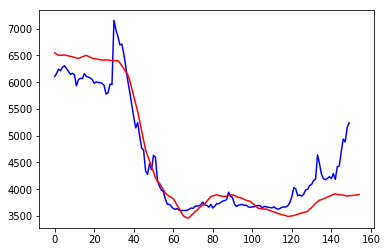

In [275]:
def prediction(time_step=15):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]],keep_prob:1})
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[15]+mean[15]
        test_predict=np.array(test_predict)*std[15]+mean[15]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)]) 
        print("The accuracy of this predict:",acc)
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b',)
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()

prediction()